In [2]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf

import pathlib
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import sys

import dotenv
dotenv.load_dotenv('/home/cesi/datascience/.env')

# Changer les données dans le .enc pour le path
DATA_MULTI_PATH = os.environ.get('DATA_MULTI_PATH')
DATA_BINARY_PATH = os.environ.get('DATA_BINARY_PATH')
SCRIPT_PATH = os.environ.get('SCRIPT_PATH')
WEIGHT_PATH = os.environ.get('WEIGHT_PATH')
MODELS_PATH = os.environ.get('MODELS_PATH')

sys.path.insert(0, SCRIPT_PATH)
sys.path.insert(1, MODELS_PATH)

# scripts
import plotResults
import createTrainingData

# models
import resnet50
import homemade
import VVG19
# import xception


2023-10-04 09:49:10.281988: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-04 09:49:10.282031: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-04 09:49:10.282057: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-04 09:49:10.288688: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# GRRR Pawww

# MODEL_CHOSEN = 'resnet50'
# MODEL_CHOSEN = 'homemade'
MODEL_CHOSEN = 'VGG19'
# MODEL_CHOSEN = 'xception'

IMAGE_H, IMAGE_W = 150, 150
BATCH_SIZE = 128
min_h = 25
min_w = 25

EPOCHS = 15

# Si on veut faire une classification binaire ou multi
BINARY_MODE = True

if(BINARY_MODE):
    data_dir = DATA_BINARY_PATH
else:
    data_dir = DATA_MULTI_PATH


In [4]:
# Alimentation des train/test set
train_set, test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=.2,
  subset='both',
  image_size=(IMAGE_H, IMAGE_W),
  seed=42,
  batch_size=BATCH_SIZE
)

class_names = train_set.class_names
num_classes = len(class_names)

Found 40801 files belonging to 2 classes.
Using 32641 files for training.
Using 8160 files for validation.


2023-10-04 09:53:23.139585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-04 09:53:23.169500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-04 09:53:23.169540: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-04 09:53:23.170656: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-04 09:53:23.170685: I tensorflow/compile

In [5]:
match(MODEL_CHOSEN):
    case 'resnet50':
        model = resnet50.build((IMAGE_H, IMAGE_W), num_classes)
    case 'homemade':
        model = homemade.build((IMAGE_H, IMAGE_W), num_classes)
    case 'VGG19':
        model = VVG19.build((IMAGE_H, IMAGE_W), num_classes)
    # case 'xception':
    #     model = xception.build((IMAGE_H, IMAGE_W), num_classes)

80134624/80134624 [==============================] - 3s 0us/step


In [6]:
path = createTrainingData.create_training_data(WEIGHT_PATH, model, MODEL_CHOSEN, num_classes, IMAGE_H, IMAGE_W, BATCH_SIZE)

checkpoint_path = path+"/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

weights_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch')

history = model.fit(train_set, epochs=EPOCHS, validation_data=test_set, callbacks=[weights_callback])

Epoch 1/15


2023-10-04 09:53:38.343871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-10-04 09:53:50.250770: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd39414c5f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-04 09:53:50.250811: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro P4000, Compute Capability 6.1
2023-10-04 09:53:50.273212: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-04 09:53:50.406516: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


256/256 [==============================] - ETA: 0s - loss: 0.5676 - accuracy: 0.9335

2023-10-04 09:56:05.747281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 1: saving model to /home/cesi/datascience/project/weights/2023_10_04_09_53_30/cp-0001.ckpt
256/256 [==============================] - 183s 638ms/step - loss: 0.5676 - accuracy: 0.9335 - val_loss: 0.1157 - val_accuracy: 0.9604
Epoch 2/15
255/256 [============================>.] - ETA: 0s - loss: 0.1016 - accuracy: 0.9639

2023-10-04 09:58:43.099840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 2: saving model to /home/cesi/datascience/project/weights/2023_10_04_09_53_30/cp-0002.ckpt
256/256 [==============================] - 148s 561ms/step - loss: 0.1016 - accuracy: 0.9639 - val_loss: 0.1044 - val_accuracy: 0.9664
Epoch 3/15
255/256 [============================>.] - ETA: 0s - loss: 0.0747 - accuracy: 0.9751

2023-10-04 10:01:14.018490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 3: saving model to /home/cesi/datascience/project/weights/2023_10_04_09_53_30/cp-0003.ckpt
256/256 [==============================] - 151s 574ms/step - loss: 0.0747 - accuracy: 0.9751 - val_loss: 0.1226 - val_accuracy: 0.9650
Epoch 4/15
255/256 [============================>.] - ETA: 0s - loss: 0.0709 - accuracy: 0.9770

2023-10-04 10:03:37.756490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 4: saving model to /home/cesi/datascience/project/weights/2023_10_04_09_53_30/cp-0004.ckpt
256/256 [==============================] - 143s 545ms/step - loss: 0.0709 - accuracy: 0.9770 - val_loss: 0.1162 - val_accuracy: 0.9670
Epoch 5/15
255/256 [============================>.] - ETA: 0s - loss: 0.0475 - accuracy: 0.9835

2023-10-04 10:06:00.656846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 5: saving model to /home/cesi/datascience/project/weights/2023_10_04_09_53_30/cp-0005.ckpt
256/256 [==============================] - 143s 544ms/step - loss: 0.0475 - accuracy: 0.9835 - val_loss: 0.1261 - val_accuracy: 0.9689
Epoch 6/15
255/256 [============================>.] - ETA: 0s - loss: 0.0484 - accuracy: 0.9843

2023-10-04 10:08:24.178750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 6: saving model to /home/cesi/datascience/project/weights/2023_10_04_09_53_30/cp-0006.ckpt
256/256 [==============================] - 143s 543ms/step - loss: 0.0484 - accuracy: 0.9843 - val_loss: 0.1417 - val_accuracy: 0.9635
Epoch 7/15
255/256 [============================>.] - ETA: 0s - loss: 0.0444 - accuracy: 0.9862

2023-10-04 10:10:47.518502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 7: saving model to /home/cesi/datascience/project/weights/2023_10_04_09_53_30/cp-0007.ckpt
256/256 [==============================] - 144s 546ms/step - loss: 0.0444 - accuracy: 0.9862 - val_loss: 0.1486 - val_accuracy: 0.9659
Epoch 8/15
255/256 [============================>.] - ETA: 0s - loss: 0.0387 - accuracy: 0.9881

2023-10-04 10:13:12.364706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 8: saving model to /home/cesi/datascience/project/weights/2023_10_04_09_53_30/cp-0008.ckpt
256/256 [==============================] - 145s 549ms/step - loss: 0.0387 - accuracy: 0.9881 - val_loss: 0.1604 - val_accuracy: 0.9686
Epoch 9/15
255/256 [============================>.] - ETA: 0s - loss: 0.0459 - accuracy: 0.9853

2023-10-04 10:15:36.292347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 9: saving model to /home/cesi/datascience/project/weights/2023_10_04_09_53_30/cp-0009.ckpt
256/256 [==============================] - 144s 547ms/step - loss: 0.0459 - accuracy: 0.9853 - val_loss: 0.1470 - val_accuracy: 0.9700
Epoch 10/15
255/256 [============================>.] - ETA: 0s - loss: 0.0379 - accuracy: 0.9884

2023-10-04 10:18:00.802539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 10: saving model to /home/cesi/datascience/project/weights/2023_10_04_09_53_30/cp-0010.ckpt
256/256 [==============================] - 144s 548ms/step - loss: 0.0379 - accuracy: 0.9884 - val_loss: 0.1896 - val_accuracy: 0.9685
Epoch 11/15
255/256 [============================>.] - ETA: 0s - loss: 0.0369 - accuracy: 0.9885

2023-10-04 10:20:24.727323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 11: saving model to /home/cesi/datascience/project/weights/2023_10_04_09_53_30/cp-0011.ckpt
256/256 [==============================] - 144s 546ms/step - loss: 0.0369 - accuracy: 0.9885 - val_loss: 0.1540 - val_accuracy: 0.9694
Epoch 12/15
255/256 [============================>.] - ETA: 0s - loss: 0.0411 - accuracy: 0.9873

2023-10-04 10:22:49.789122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 12: saving model to /home/cesi/datascience/project/weights/2023_10_04_09_53_30/cp-0012.ckpt
256/256 [==============================] - 145s 552ms/step - loss: 0.0411 - accuracy: 0.9873 - val_loss: 0.1986 - val_accuracy: 0.9668
Epoch 13/15
255/256 [============================>.] - ETA: 0s - loss: 0.0382 - accuracy: 0.9898

2023-10-04 10:25:14.548423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 13: saving model to /home/cesi/datascience/project/weights/2023_10_04_09_53_30/cp-0013.ckpt
256/256 [==============================] - 145s 550ms/step - loss: 0.0382 - accuracy: 0.9898 - val_loss: 0.1906 - val_accuracy: 0.9680
Epoch 14/15
255/256 [============================>.] - ETA: 0s - loss: 0.0386 - accuracy: 0.9891

2023-10-04 10:27:38.052944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 14: saving model to /home/cesi/datascience/project/weights/2023_10_04_09_53_30/cp-0014.ckpt
256/256 [==============================] - 143s 545ms/step - loss: 0.0386 - accuracy: 0.9891 - val_loss: 0.2026 - val_accuracy: 0.9699
Epoch 15/15
255/256 [============================>.] - ETA: 0s - loss: 0.0252 - accuracy: 0.9914

2023-10-04 10:30:01.249053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9



Epoch 15: saving model to /home/cesi/datascience/project/weights/2023_10_04_09_53_30/cp-0015.ckpt
256/256 [==============================] - 143s 543ms/step - loss: 0.0252 - accuracy: 0.9914 - val_loss: 0.1888 - val_accuracy: 0.9685


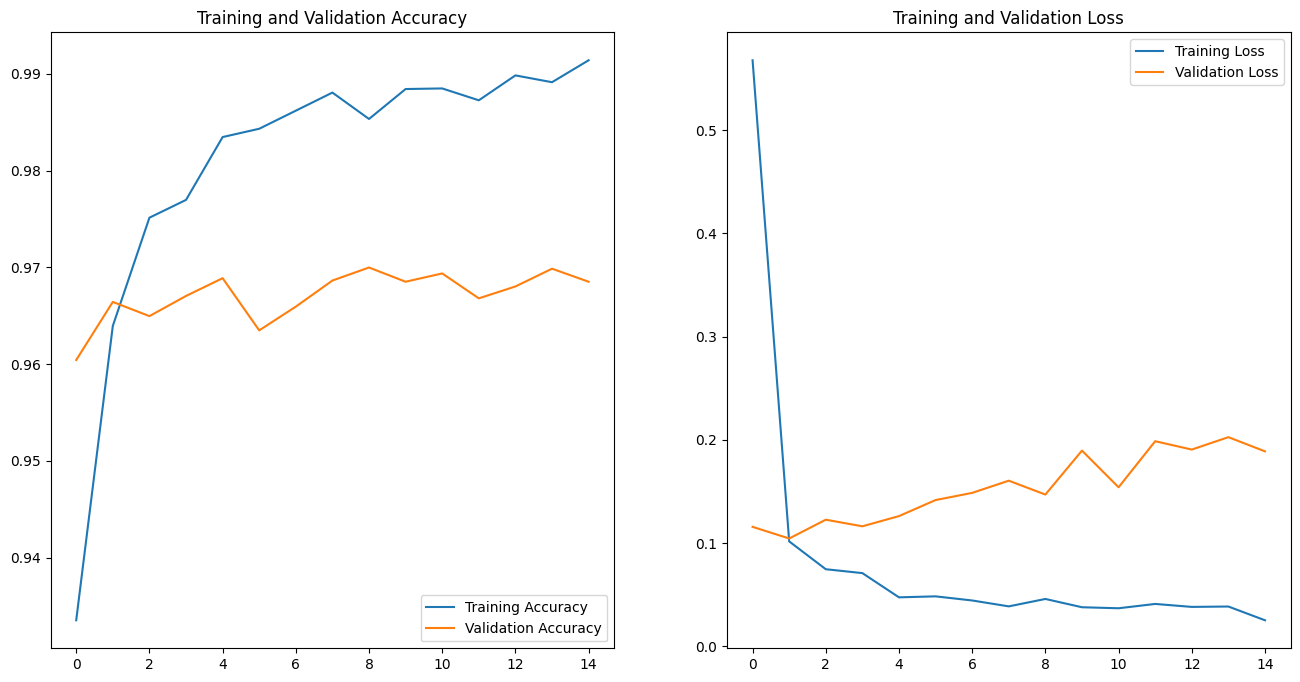

In [7]:
epochs_range = range(EPOCHS)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.savefig(path+"/metrics.png")

plt.show()



In [8]:
# Load de la meilleur epoch
model_to_load_path = WEIGHT_PATH+"2023_10_04_09_53_30/cp-0001.ckpt"

model.load_weights(model_to_load_path)

In [9]:
predictions = model.predict(test_set)

24/64 [==========>...................] - ETA: 18s

2023-10-04 11:05:43.362733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/64 [===========================>..] - ETA: 1s

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


64/64 [==============================] - 30s 468ms/step


In [10]:
loss, acc = model.evaluate(test_set)

23/64 [=========>....................] - ETA: 17s - loss: 0.1122 - accuracy: 0.9606

2023-10-04 11:06:13.341588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/64 [===========================>..] - ETA: 1s - loss: 0.1166 - accuracy: 0.9595

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


64/64 [==============================] - 29s 441ms/step - loss: 0.1157 - accuracy: 0.9604


In [11]:
full_tests_images = []
full_tests_labels = []
for i,(batch_images, batch_labels) in enumerate(test_set):
    for im in batch_images:
        full_tests_images.append(im)
    for res in batch_labels:
        full_tests_labels.append(int(res))

2023-10-04 11:06:42.096814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


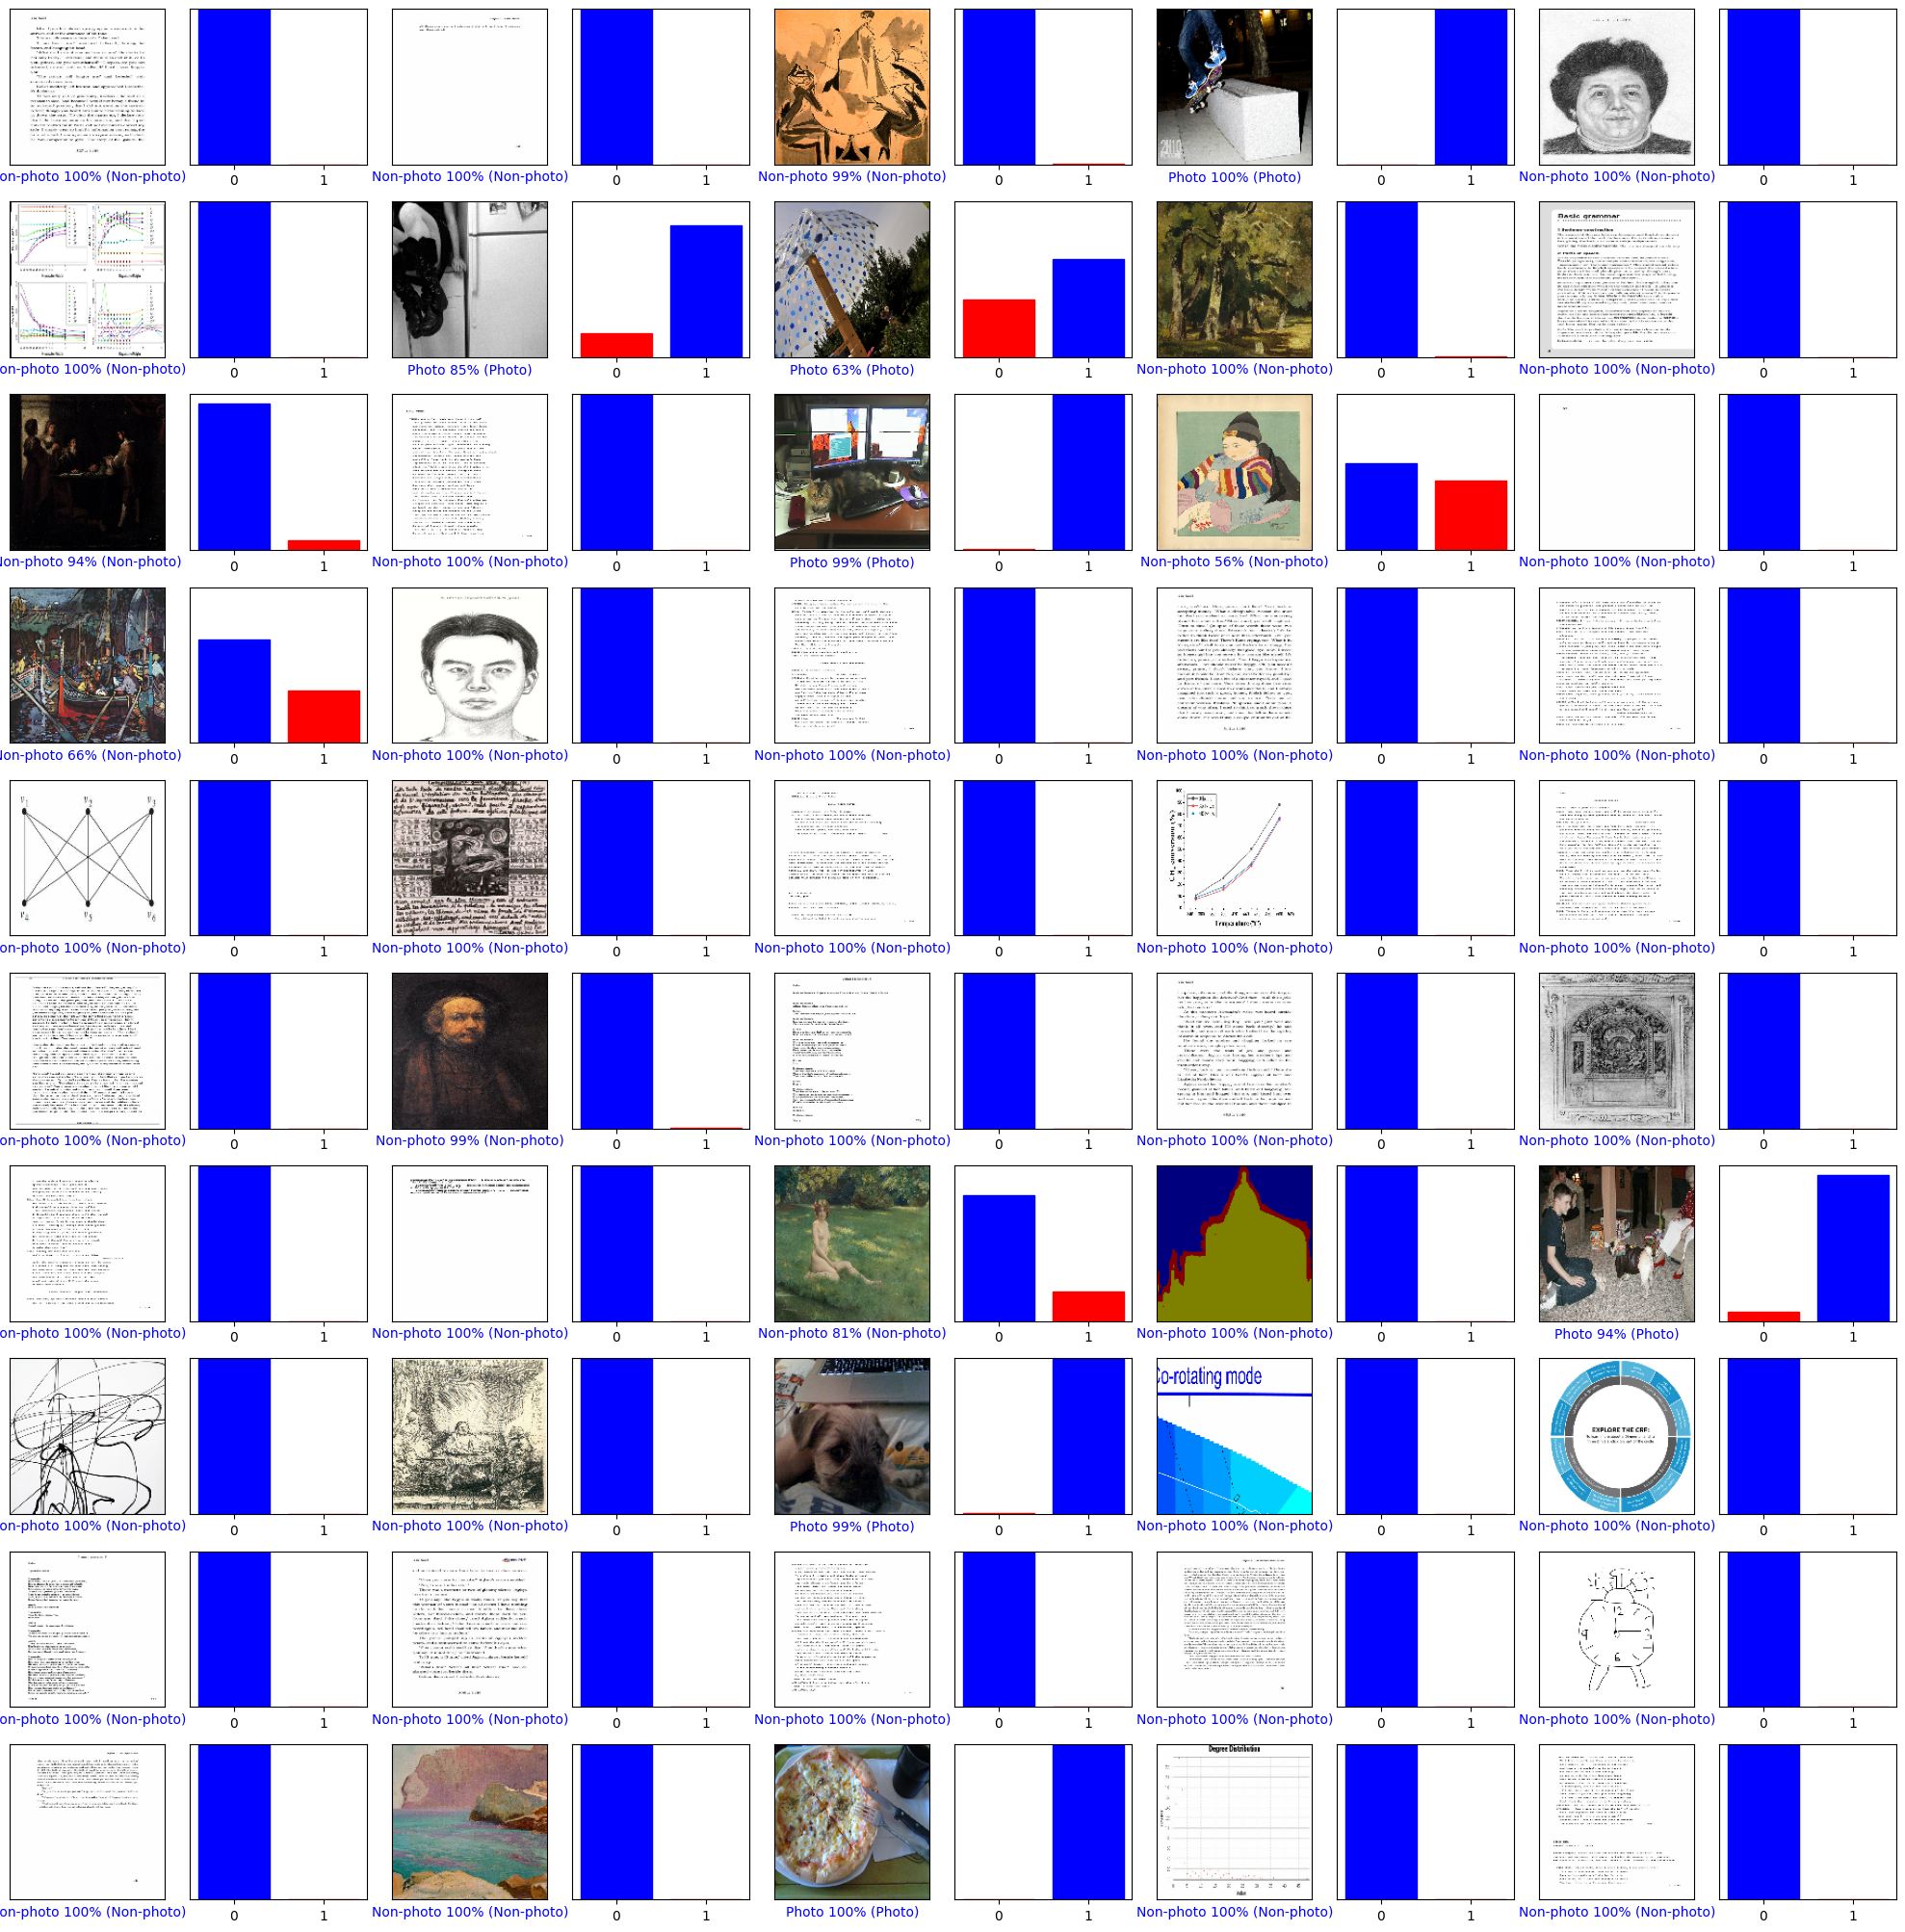

In [58]:
plotResults.plot_results(num_classes == 2, predictions, full_tests_labels, full_tests_images, class_names=class_names, save_path=path, index_start=0, images_displayed=64)

In [ ]:
tp = 0
fp = 0
fn = 0
tn = 0

for i in range(len(predictions)):
    predicted_label = class_names[np.argmax(predictions[i])]
    true_label = class_names[full_tests_labels[i]]

    if true_label == 'Photo' and predicted_label == 'Photo':
        tp += 1
    elif true_label == 'Photo' and predicted_label != 'Photo':
        fn += 1
    elif true_label != 'Photo' and predicted_label == 'Photo':
        fp += 1
    elif true_label != 'Photo' and predicted_label != 'Photo':
        tn += 1    

In [ ]:
print(tp, fp, fn, tn)

In [ ]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)
accuracy = (tp + tn) / (tp + tn + fp + fn)
print("precision:",precision, "recall:", recall, "f1:",f1, "accuracy:", accuracy)

In [ ]:
print("Confusion Matrix : ")
print(f"[{tp}] [{fp}]")
print(f"[{fn}] [{tn}]")